# Read multitone waveform `.mat` files

This notebook loads all `weightsN*.mat` files in the current folder and interprets them as:

- `fn`: tone offsets around the 875 MHz carrier.
- `weights`: complex tone weights (`rows = tones`, `columns = input power points`).
- `Pdc`: model-predicted DC values for the optimized weights.
- `inPwrVec`: input RF power vector in mW.

Filename convention: in `weightsNx.mat`, `x` is the number of tones.

In [23]:
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.io import loadmat
except Exception as exc:
    raise ImportError(
        "Could not import scipy.io.loadmat. Install compatible numpy/scipy versions first."
    ) from exc

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


In [24]:
BW_HZ = 20e6
FC_HZ = 875e6
DATA_DIR = Path(".")

print(f"Data dir: {DATA_DIR.resolve()}")
print(f"Assumed bandwidth: {BW_HZ/1e6:.1f} MHz, carrier: {FC_HZ/1e6:.1f} MHz")


Data dir: C:\Users\Calle\OneDrive\Documenten\GitHub\RF-waveform-optimization
Assumed bandwidth: 20.0 MHz, carrier: 875.0 MHz


In [25]:
def parse_n_tones(path: Path) -> int:
    match = re.search(r"weightsN(\d+)\.mat$", path.name)
    if not match:
        raise ValueError(f"Unexpected filename format: {path.name}")
    return int(match.group(1))


def _to_1d(x):
    return np.atleast_1d(np.asarray(x).squeeze())


def _to_2d(x):
    arr = np.asarray(x).squeeze()
    if arr.ndim == 0:
        return arr.reshape(1, 1)
    if arr.ndim == 1:
        return arr[:, None]
    return arr


def load_waveform_file(path: Path) -> dict:
    mat = loadmat(path, squeeze_me=True)
    required = ["fn", "weights", "Pdc", "inPwrVec"]
    missing = [k for k in required if k not in mat]
    if missing:
        raise KeyError(f"{path.name} missing fields: {missing}")

    fn = _to_1d(mat["fn"])
    weights = _to_2d(mat["weights"])
    pdc = _to_1d(mat["Pdc"]).astype(float)
    in_pwr_mw = _to_1d(mat["inPwrVec"]).astype(float)

    # If dimensions are transposed in file, align so rows map to tones.
    if weights.shape[0] != fn.size and weights.shape[1] == fn.size:
        weights = weights.T

    return {
        "file": path,
        "n_tones": parse_n_tones(path),
        "fn": fn,
        "weights": weights,
        "Pdc": pdc,
        "inPwrVec_mW": in_pwr_mw,
        "inPwrVec_dBm": 10 * np.log10(in_pwr_mw),
        "f_abs_Hz": FC_HZ + fn,
    }


In [26]:
mat_files = sorted(DATA_DIR.glob("weightsN*.mat"), key=parse_n_tones)
if not mat_files:
    raise FileNotFoundError("No files matching weightsN*.mat found in the current directory.")

waveforms = [load_waveform_file(p) for p in mat_files]
print(f"Loaded {len(waveforms)} files: {[w['file'].name for w in waveforms]}")


Loaded 4 files: ['weightsN4.mat', 'weightsN8.mat', 'weightsN16.mat', 'weightsN32.mat']


In [27]:
summary = pd.DataFrame(
    {
        "file": [w["file"].name for w in waveforms],
        "n_tones_from_name": [w["n_tones"] for w in waveforms],
        "fn_len": [w["fn"].size for w in waveforms],
        "weights_shape": [w["weights"].shape for w in waveforms],
        "n_input_powers": [w["inPwrVec_mW"].size for w in waveforms],
        "Pdc_len": [w["Pdc"].size for w in waveforms],
        "input_power_min_mW": [np.min(w["inPwrVec_mW"]) for w in waveforms],
        "input_power_max_mW": [np.max(w["inPwrVec_mW"]) for w in waveforms],
    }
)

summary


,file,n_tones_from_name,fn_len,weights_shape,n_input_powers,Pdc_len,input_power_min_mW,input_power_max_mW
0,weightsN4.mat,4,4,"(4, 16)",16,16,0.001,1.0
1,weightsN8.mat,8,8,"(8, 16)",16,16,0.001,1.0
2,weightsN16.mat,16,16,"(16, 16)",16,16,0.001,1.0
3,weightsN32.mat,32,32,"(32, 16)",16,16,0.001,1.0


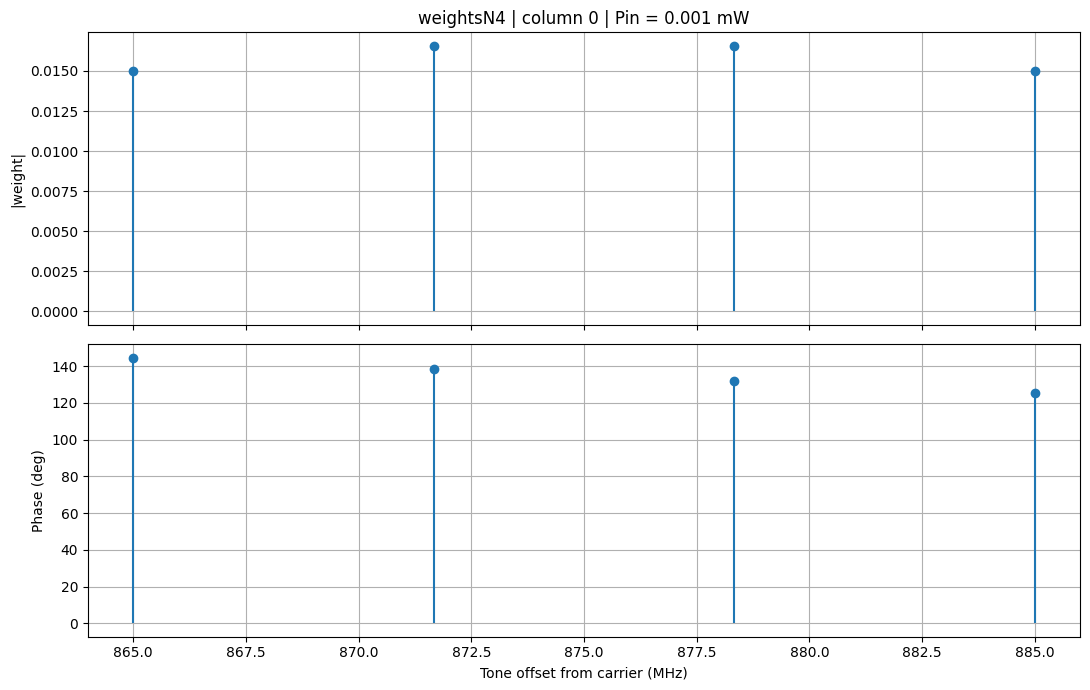

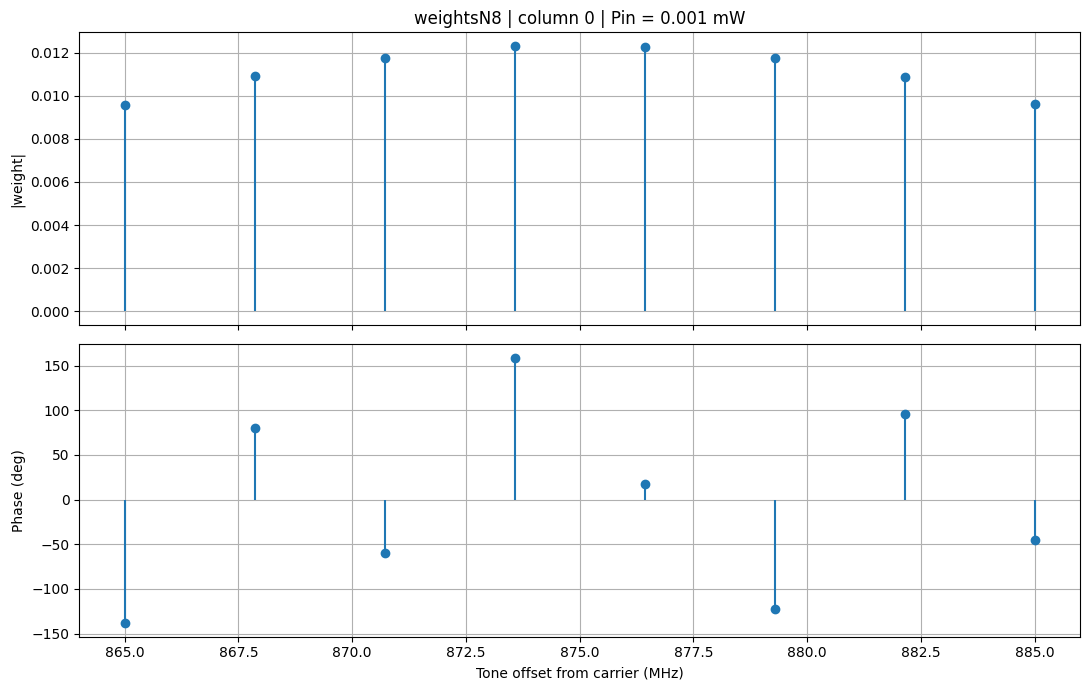

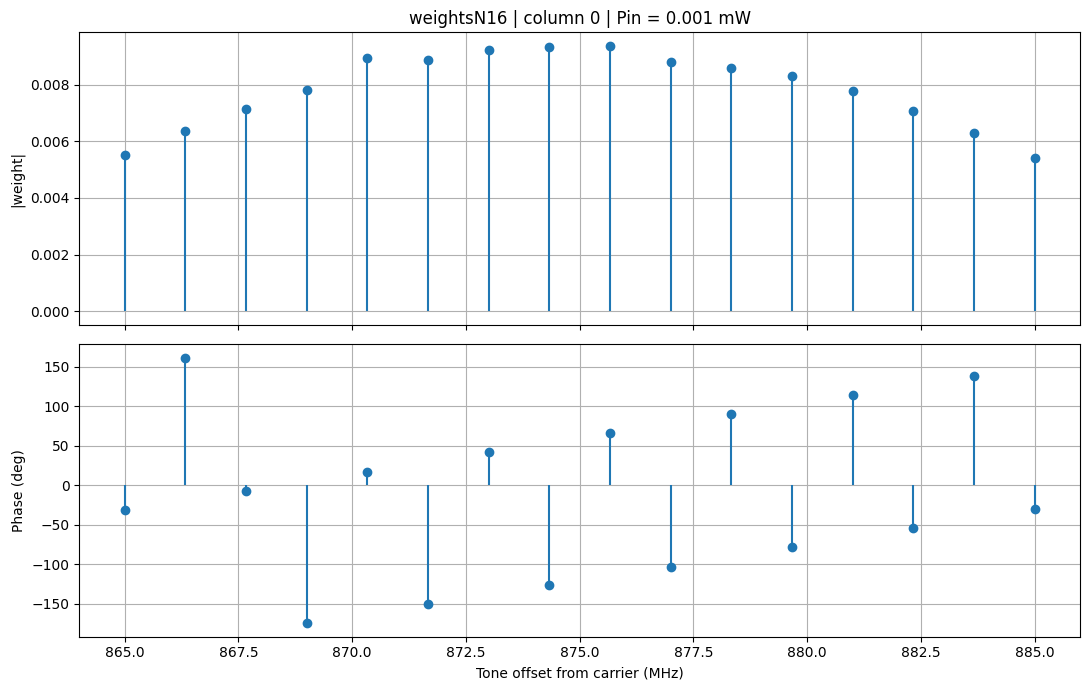

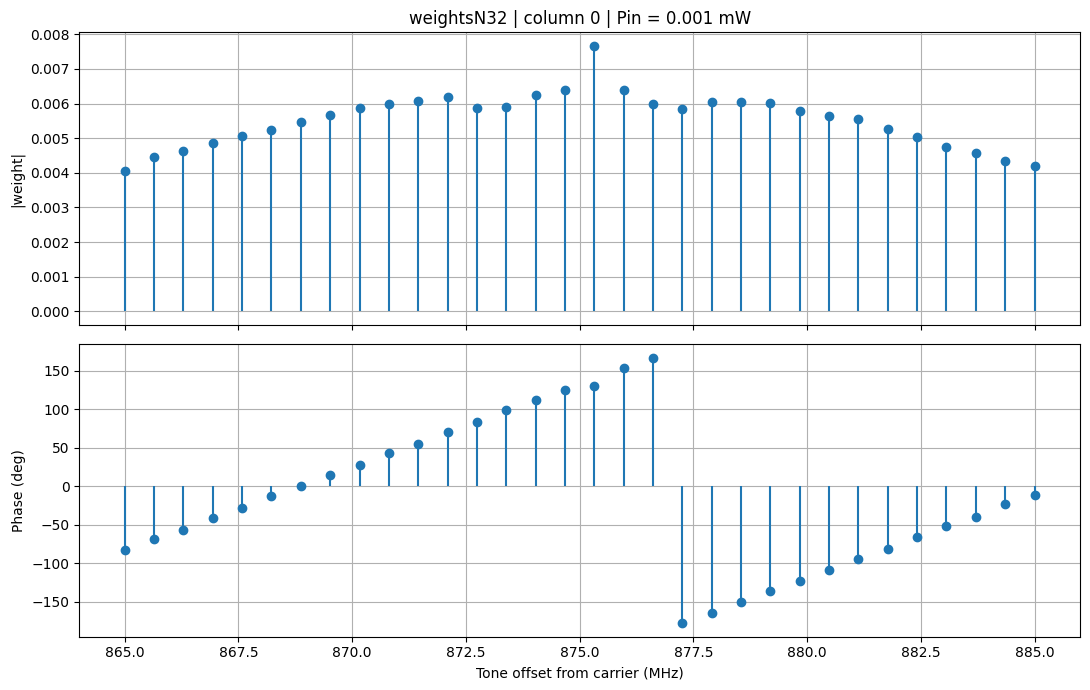

In [33]:
# Choose a waveform and a power-index column for detailed visualization.
selected_n_tones = 32
selected_power_idx = 0

for wf in waveforms:
    if wf is None:
        available = [w["n_tones"] for w in waveforms]
        raise ValueError(f"N={selected_n_tones} not available. Choose from {available}")

    selected_power_idx = int(np.clip(selected_power_idx, 0, wf["weights"].shape[1] - 1))
    tone_offsets_mhz = wf["fn"] / 1e6
    w_col = wf["weights"][:, selected_power_idx]

    fig, ax = plt.subplots(2, 1, figsize=(11, 7), sharex=True)
    ax[0].stem(tone_offsets_mhz, np.abs(w_col), basefmt=" ")
    ax[0].set_ylabel("|weight|")
    ax[0].set_title(
        f"weightsN{wf['n_tones']} | column {selected_power_idx} | "
        f"Pin = {wf['inPwrVec_mW'][selected_power_idx]:.3f} mW"
    )

    ax[1].stem(tone_offsets_mhz, np.angle(w_col, deg=True), basefmt=" ")
    ax[1].set_xlabel("Tone offset from carrier (MHz)")
    ax[1].set_ylabel("Phase (deg)")
    plt.tight_layout()


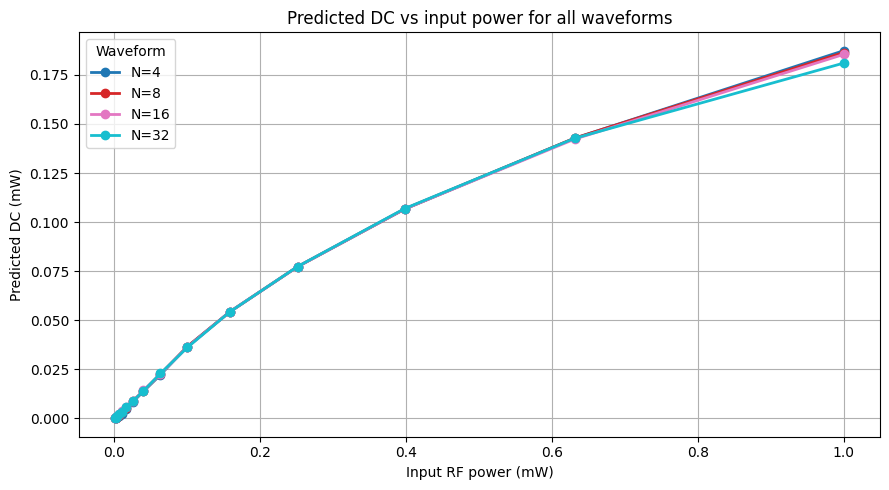

In [29]:
# All waveforms on one figure with different colors.
fig, ax = plt.subplots(figsize=(9, 5))
colors = plt.cm.tab10(np.linspace(0, 1, len(waveforms)))

for c, w in zip(colors, waveforms):
    ax.plot(
        w["inPwrVec_mW"],
        w["Pdc"],
        marker="o",
        color=c,
        linewidth=2,
        label=f"N={w['n_tones']}",
    )

ax.set_xlabel("Input RF power (mW)")
ax.set_ylabel("Predicted DC (mW)")
ax.set_title("Predicted DC vs input power for all waveforms")
ax.legend(title="Waveform", frameon=True)
plt.tight_layout()


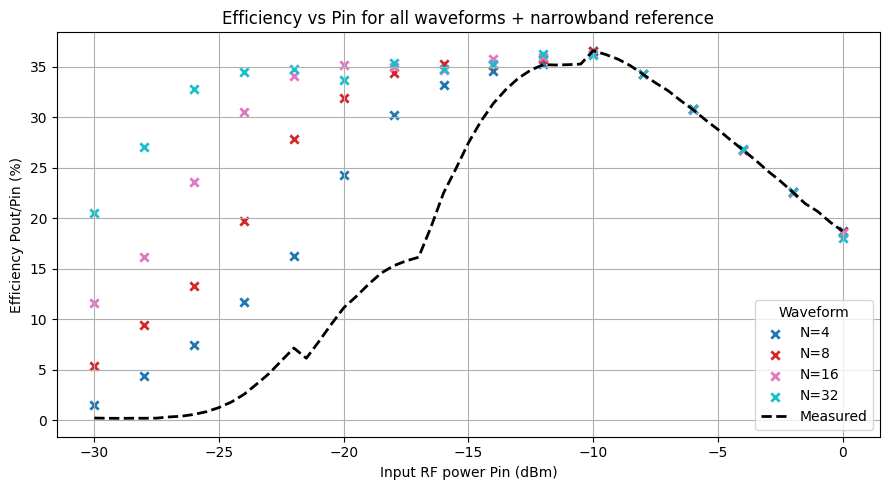

In [32]:
# Efficiency plot (assuming Pout = Pdc), with narrowband reference overlay.
fig, ax = plt.subplots(figsize=(9, 5))
colors = plt.cm.tab10(np.linspace(0, 1, len(waveforms)))

for c, w in zip(colors, waveforms):
    pin = np.asarray(w["inPwrVec_mW"], dtype=float)
    pout = np.asarray(w["Pdc"], dtype=float)
    eta = np.divide(pout, pin, out=np.full_like(pout, np.nan, dtype=float), where=pin > 0)
    ax.scatter(10*np.log10(pin), eta * 100.0, marker="x", color=c, linewidth=2, label=f"N={w['n_tones']}")

# Optional overlay: narrowband measured efficiency curve.
nb_csv = Path("harvester-chart-data.csv")
if nb_csv.exists():
    nb = pd.read_csv(nb_csv)
    required_cols = {"level_dbm", "efficiency"}
    if required_cols.issubset(nb.columns):
        nb = nb.sort_values("level_dbm")
        ax.plot(
            nb["level_dbm"].to_numpy(dtype=float),
            nb["efficiency"].to_numpy(dtype=float),
            color="black",
            linestyle="--",
            linewidth=2,
            label="Measured",
            zorder=5,
        )
    else:
        print(f"Skipping {nb_csv}: missing columns {required_cols}")
else:
    print(f"Skipping narrowband overlay: {nb_csv} not found")

ax.set_xlabel("Input RF power Pin (dBm)")
ax.set_ylabel("Efficiency Pout/Pin (%)")
ax.set_title("Efficiency vs Pin for all waveforms + narrowband reference")
ax.legend(title="Waveform", frameon=True)
plt.tight_layout()


## Notes

- Tones are expected between `-BW/2` and `+BW/2` with `BW = 20 MHz`.
- Absolute tone frequencies are `875e6 + fn` (Hz).
- Each `weights` column corresponds to one sampled RF input power in `inPwrVec`.
- Efficiency in the added plot is computed as `Pdc / inPwrVec` (i.e., `Pout = Pdc`).
- The same plot overlays narrowband measured efficiency from `harvester-chart-data.csv` (`level_dbm` vs `efficiency`).
- If needed, change `selected_n_tones` and `selected_power_idx` to inspect another waveform or power point.